In [2]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
import inspect

top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from longestpath.gen import gen_num_edges
from benchmarking import RandomParams, Benchmark, new_random_benchmark, Solver, new_graph_file_benchmark, new_benchmark
import re
from longestpath.utils import with_timeout
from longestpath.kalp import solve_KaLP

In [3]:
G = gen_num_edges(1000, 2000)
with_timeout(2)(Solver("brute", "FAST_BOUND").run)(G)

In [5]:
def generate():
  return [
    gen_num_edges(1000, round(1000 * degree))
      for degree in np.arange(1, 2.1, 0.1) for _ in range(1)
  ]

params_code = inspect.getsource(generate)
graphs = generate()

benchmark = new_benchmark(graphs, solvers=[
	# Solver("brute", "FAST_BOUND"),
	Solver("kalp"),
	# Solver("brute", "BRUTE_FORCE"),
], params_code = params_code, override_benchmark_path="../benchmarks/test")

benchmark.benchmark_path


'../benchmarks/test(5)'

In [74]:
benchmark = Benchmark.load("../benchmarks/test(15)")

In [6]:
benchmark.run(retryFailures=True, timeout=2)


graph: 0.txt, solver: kalp() ... 

❌ (timeout)
graph: 1.txt, solver: kalp() ... ❌ (timeout)
graph: 2.txt, solver: kalp() ... ❌ (timeout)
graph: 3.txt, solver: kalp() ... ❌ (timeout)
graph: 4.txt, solver: kalp() ... ❌ (timeout)
graph: 5.txt, solver: kalp() ... ❌ (timeout)
graph: 6.txt, solver: kalp() ... ❌ (timeout)
graph: 7.txt, solver: kalp() ... ❌ (timeout)
graph: 8.txt, solver: kalp() ... ❌ (timeout)
graph: 9.txt, solver: kalp() ... ❌ (timeout)


SystemExit: 130

/home/rob/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [90]:
df = benchmark.get_dataframe()
df

,path,run_time,length,solver,graph_id,solver_name,vertices,edges,average_out_degree
0,"[5, 25, 33, 13, 31, 23, 17]",0.000018,6,0,0,brute('FAST_BOUND'),50,50,1.0
1,"[26, 12, 27, 49, 1, 45, 2, 25, 20, 43, 15]",0.000012,10,0,1,brute('FAST_BOUND'),50,55,1.1
2,"[11, 21, 47, 1, 26, 2]",0.000009,5,0,2,brute('FAST_BOUND'),50,60,1.2
3,"[16, 3, 39, 15, 28, 42, 2, 27, 13, 34, 44]",0.000009,10,0,3,brute('FAST_BOUND'),50,65,1.3
4,"[45, 19, 46, 32, 24, 38, 26, 23, 14]",0.000009,8,0,4,brute('FAST_BOUND'),50,70,1.4
5,"[42, 1, 0, 46, 14, 45, 44, 36, 24, 20, 8, 38, ...",0.000022,16,0,5,brute('FAST_BOUND'),50,75,1.5
6,"[7, 32, 16, 1, 28, 12, 48, 21, 3, 41, 38, 20, ...",0.000053,22,0,6,brute('FAST_BOUND'),50,80,1.6
7,"[44, 41, 30, 18, 33, 9, 1, 2, 6, 45, 26, 20, 4...",0.000024,22,0,7,brute('FAST_BOUND'),50,85,1.7
8,"[41, 49, 11, 9, 10, 29, 33, 27, 12, 0, 28, 17,...",0.000789,25,0,8,brute('FAST_BOUND'),50,90,1.8
9,"[21, 4, 31, 48, 7, 35, 11, 6, 5, 14, 23, 16, 3...",0.000798,27,0,9,brute('FAST_BOUND'),50,95,1.9


run_time    Axes(0.125,0.11;0.775x0.77)
dtype: object

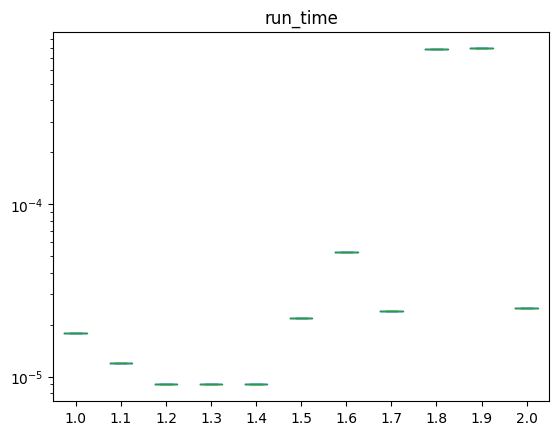

In [91]:
df[df["solver"] == 0][["run_time", "average_out_degree"]].plot.box(by="average_out_degree", logy=True)


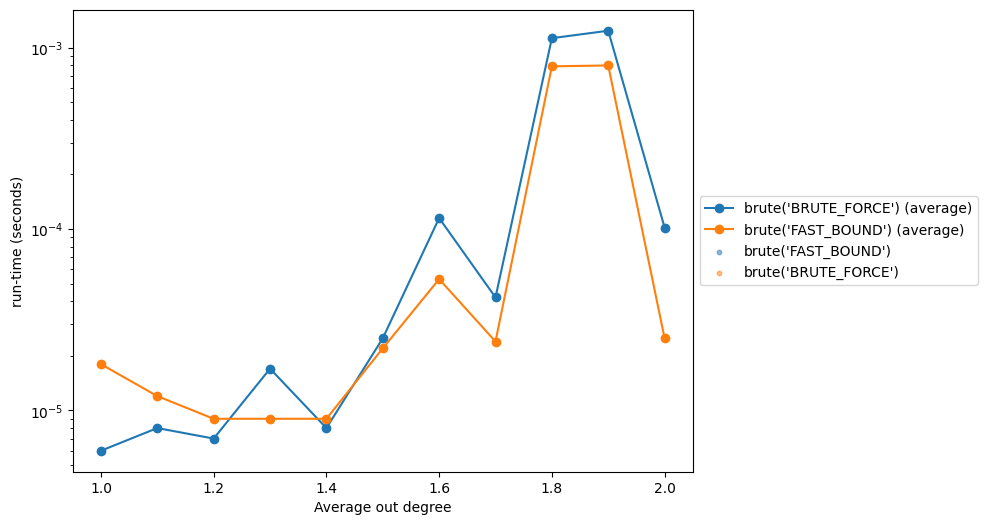

In [92]:
view = df[['average_out_degree', 'solver_name','length', 'run_time']]

to_plot = df.groupby(['average_out_degree', 'solver', 'solver_name']).agg({'run_time': 'mean'}).reset_index() \
    .pivot(index='average_out_degree', columns='solver_name', values='run_time') \
    .rename(columns=lambda x: x + " (average)");


to_plot.plot(style="o-")

for solver_name in solver_names:
    solver_df = df[df["solver_name"] == solver_name]  # Select rows where run-time is not null
    plt.scatter(solver_df['average_out_degree'], solver_df['run_time'], label=solver_name, alpha=0.5, s=10)

plt.yscale('log')
# plt.xticks(np.arange(1, 4.0, 0.5))
plt.ylabel("run-time (seconds)")
plt.xlabel("Average out degree")
# plt.title("Longest path solve-time for random directed graphs with 50 vertices")
# plt.axhline(y=0.015, color='black', linestyle='--', label='run-time cutoff', linewidth=1, alpha=0.5, zorder=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# df[df["solver"] == 0].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# df[df["solver"] == 1].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# plt.ylim(0, to_plot.max().max())

plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')

In [51]:
to_plot2 = df.groupby("solver").get_group(0)[["run_time", "average_out_degree"]].sort_values(by="average_out_degree")
to_plot2


,run_time,average_out_degree
0,0.000010,1.0
1,0.000008,1.0
2,0.000012,1.0
3,0.000009,1.0
4,0.000010,1.0
...,...,...
104,0.000111,2.0
105,0.000697,2.0
106,0.001308,2.0
107,0.000577,2.0


<Axes: xlabel='average_out_degree'>

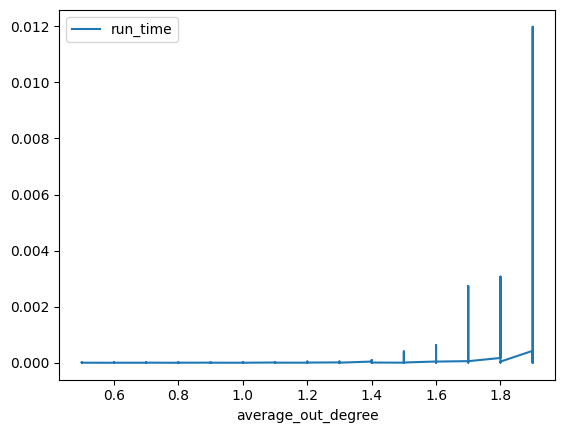

In [22]:
to_plot2.plot(x="average_out_degree", y="run_time")

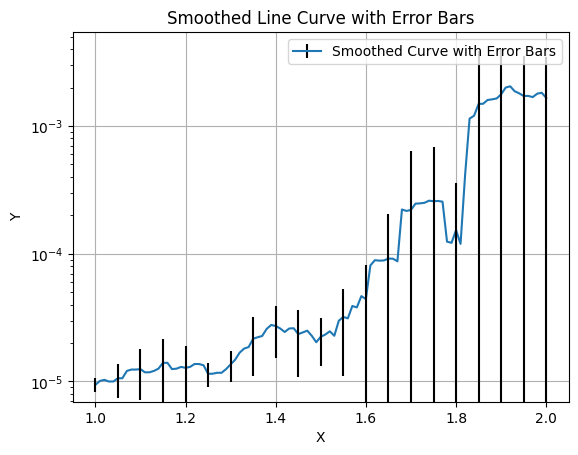

In [56]:
rolling_window = 10
df_smoothed = to_plot2.rolling(rolling_window, center=True).mean()
df_std = to_plot2.rolling(rolling_window, center=True).std()

# Plot the smoothed curve with error bars
plt.errorbar(df_smoothed['average_out_degree'], df_smoothed['run_time'], yerr=df_std['run_time'], label='Smoothed Curve with Error Bars', errorevery=5, barsabove=True, ecolor="black")
plt.xlabel('X')
plt.ylabel('Y')
plt.yscale("log")
plt.title('Smoothed Line Curve with Error Bars')
plt.legend()
plt.grid(True)
plt.show()